In [ ]:
# Aquest notebook té 25GB

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !python -m pip install dask[dataframe] --upgrade  # or python -m pip install

In [ ]:
!pip uninstall lightgbm # reinstall lightgbm to obtain the latest version in colab
!pip install lightgbm

Uninstalling lightgbm-2.2.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm-2.2.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/lightgbm/*
Proceed (y/n)? y
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0MB 6.5MB/s 


# Train

# Load data

In [ ]:
import pandas as pd
# import dask.array as da 
# import dask.dataframe as dd
import os
import numpy as np


path = './gdrive/MyDrive/validation/'
df =  pd.read_csv(path + 'part-00000', sep='', encoding='utf-8', header=None) 
all_features = ['bert', 'hashtags', 'tweet_id', 'media', 'links', 'domains', 'type',
       'language', 'timestamp', 'EWUF_user_id', 'EWUF_follower_count',
       'EWUF_following_count', 'EWUF_verified', 'EWUF_account_creation',
       'EUF_user_id', 'EUF_follower_count', 'EUF_following_count',
       'EUF_verified', 'EUF_account_creation', 'engagee_follows_engager',
       'replay_timestamp', 'retweet_timestamp', 'quote_timestamp',
       'like_timestamp']
       
df.columns = all_features

### Load/create array for not repeating tweets


In [ ]:
# unique_tweet_id = df.tweet_id.unique()
# np.random.shuffle(unique_tweet_id)

# load array
unique_tweet_id = (pd.read_csv(path + 'unique_tweet_idLOWMEM2.csv', delimiter = ';', header = None)).values.flatten()

df_train = df[df['tweet_id'].isin(unique_tweet_id[:int(unique_tweet_id.shape[0]/2)])]
df_test = df[df['tweet_id'].isin(unique_tweet_id[int(unique_tweet_id.shape[0]/2):])]
# np.savetxt(path + 'unique_tweet_id.csv', unique_tweet_id, delimiter=',', fmt='%s')

In [ ]:
df_train = df_train.sample(frac=0.4, replace=True, random_state=1) # make smaller training set

### Split with repeating tweets 

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split( df, test_size=0.5, random_state=17)

In [ ]:
df_train = df_train.sample(frac=0.4, replace=True, random_state=1) # make smaller training set

### Liberate memory

In [ ]:
del df_test; del df

# Transform

### Transformation functions

In [ ]:
from datetime import datetime


timestamp_columns = ['timestamp','EUF_account_creation', 'EWUF_account_creation','replay_timestamp','retweet_timestamp','quote_timestamp','like_timestamp']
hoursCombinations = ['EUF_time_from_creation', 'EWUF_time_from_creation', 'diff_from_creation', 'weekday', 'hoursweekday']
popular_hashtags_encoded = ['06B910C9B63253EC90A2CFEFDBCA16CE', '39C7D662C61AA442BA20D2A006EAA12E', '7E9AEB766F61E95966456D010AD862AF', '30B81B3A82D3B7BB28B0665B9BDB64B4',
                              'C1B1B9901E33AA2663BE92BE667A022A', '5C7186255EA0910671FE63609A7740C3', 'EEDFB04300BC76ECE64AE7AB8DFF999C', 'D145847A7C57F6DE2E7C16CA981F29CA',
                              '50D49D761DBC587AD19073D8A41BE4D0', '9004114120258A56A5F42E1B321E5D4D', '7A58C9993F3EDDEEE0193CF84AACB435',
                              'C97F51206BB66832B1B76DE40C7936E2', '01A8672B101954842C0D6809ADE4C250', '620B9E3FE9B8231E8767F3731E1E74E1', '1A69D94DA6E8A5D1F79192D3FB80C775', 
                              '7683BBB548DE14CCB45ACA60F0AD9B83', '86101A70061DA4A3A216AE11F48BD5E1','C442A089DA33B1C7411F3CC6274F60E2', '580CF8A679C838C2C063A631744A7B22', '05BBC3A142403B01286F8A8ABDB2EEFF', '91C8A9A97AF0D1B666ABC447B808B812',
                           '15ED32AEEAD0896AAE12BA7850052B94', '86F5C36DD25C658130A4F125005CE8EB', '95247C93BA4711381143E86AB039407E', '19875E4EA694E7A74B4025ECCF4E19CF',
                           '9B597ACF49E09186820C359759D325FF', 'D9F46EFE32A7D46EACAD96E4D552054B', 'AC6785EF8C88D1509EF755EAAEA4C875', 'BBD612D7A4C2EB59B3334456AB2D70A3',
                           '08C02CD16B3412A168D03171FA80C58E', 'C7DB5645FD9D5D8B81407F819CE78A06', '881264CF821C09C4F851A080C82CA83D']
worst_words_retweet = [
    "game", "going", "haha", "lol", "but", "watching", "work", "home", "night",
    "bed", "well", "sleep", "gonna", "hey", "tomorrow", "tired", "some",
    "back", "bored", "listening"
]

worst_words_encoded = ['11661','19090','10228','10406','10473','84532','11424','11816','16903','30113','11206','63658','11783','10261','19132','71841','11152','12014','73823','109130']

best_words_retweet = [
    "you", "twitter", "please", "retweet", "post", "blog", "social", "free",
    "media", "help", "please retweet", "great", "social media", "10", "follow",
    "how to", "top", "blog post", "check out", "new blogpost"
]

best_words_encoded = ['13028','188','20648','62893','11841','31907','12142','13961','12518','15217','20648','14772','12142','10150','28086','14796','12364','31907','43662','10751']

common_english_words = [
    'the', 'at', 'and', 'a', 'to', 'in', 'is', 'you', 'that', 'it', 'he',
    'was', 'for', 'on', 'are', 'as', 'with', 'his', 'they', 'i', 'at', 'be',
    'this', 'have', 'from', 'or', 'one', 'had', 'by', 'word', 'but', 'not',
    'what', 'all', 'were', 'we', 'when', 'your', 'can', 'said', 'there', 'use',
    'an', 'each', 'which', 'she', 'do', 'how', 'their', 'if', 'will', 'up',
    'other', 'about', 'out', 'many', 'then', 'them', 'these', 'so', 'some',
    'her', 'would', 'make', 'like', 'him', 'into', 'time', 'has', 'look',
    'two', 'more', 'write', 'go', 'see', 'number', 'no', 'way', 'could',
    'people', 'my', 'than', 'first', 'water', 'been', 'call', 'who', 'oil',
    'its', 'now', 'find', 'long', 'down', 'day', 'did', 'get', 'come', 'made',
    'may', 'part', '[SEP]', '[CLS]', 'https', 'http'
]

common_words_encoded = ['10105','10160','10111','169','10114','10106','10124','13028','10189','10271','10261','10134','10142','10135','10301','10146',
'10169','10226','10689','177','10160','10347','10531','10529','10188','10345','10464','10374','10155','12307','10473','10472','12976','10435','10309',
'11951','10841','20442','10944','12415','11155','11760','10151','11948','10319','10833','10149','14796','10455','12277','11337','10741','10684','10978',
'10950','11299','11059','11345','11762','10380','11152','10485','10894','13086','11850','10957','10708','10635','10393','25157','10551','10798','28685',
'11783','12888','11487','10192','13170','12174','11426','15127','11084','10422','12286','10590','20575','10479','21073','10474','11858','17860','11695',
'12935','11940','12172','15329','10678','11019','11387','10668','102','101','14120','10556']

addmited_punctuations = '100'

encoded_punctuations = ['106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','131','132','133','134','135','136','137','164','165','166','167','168','100','195','196','197','198']

text_columns = [
    'length_tweet', 'num_unique_words', 'ratio_unique_words',
    'contains_worst_words', 'contains_best_words', 'contains_reply',
    "max_token_len", "min_token_len", "mean_token_len", "number_of_UNK",
    "ratio_of_UNK", "number_of_punctuations", "ratio_of_punctuations",
    "kinda_num_of_keywords", "num_of_keywords", "ratio_of_keywords",
    "length_tweet_tokens" #, "tf_idf"
]

def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    #assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    mylist_of_strings = []
    for x in mylist:
        mylist_of_strings.append(str(x))

    return mylist_of_strings

def transform_basic_features(df, timestamp_columns = timestamp_columns):
    df[timestamp_columns] = df[timestamp_columns].apply(lambda x: pd.to_datetime(x,unit='s'))

    df['EWUF_follow_ratio'] = (df['EWUF_following_count']/ df['EWUF_follower_count'].apply(lambda x : x+1e-6) )
    df['cross_following_ratio'] = (df['EWUF_following_count']/ df['EUF_following_count'].apply(lambda x : x+1e-6) )
    df['cross_ratio1'] = (df['EWUF_following_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )
    df['cross_ratio2'] = (df['EUF_following_count']/ df['EWUF_follower_count'].apply(lambda x : x+1e-6) )
    df['EUF_follow_ratio'] = (df['EUF_following_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )
    df['cross_follower_ratio'] = (df['EWUF_follower_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )

    df['EUF_verified'] = df['EUF_verified'].astype(int)
    df['EWUF_verified'] = df['EUF_verified'].astype(int)
    df['EUF_time_from_creation'] = df.EUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
    df['EWUF_time_from_creation'] =  df.EWUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
    df['diff_from_creation'] = (df.EUF_time_from_creation - df.EWUF_time_from_creation)
    df['engagee_follows_engager'] = df['engagee_follows_engager'].astype(int)
    df['ratioxratio'] = df['EWUF_follow_ratio']*df['EUF_follow_ratio']
    df['relevance'] = df['EUF_verified'] & df['EWUF_verified']

    df['replay_bool'] = df['replay_timestamp'].notna().astype(int)
    df['retweet_bool'] = df['retweet_timestamp'].notna().astype(int)
    df['quote_bool'] = df['quote_timestamp'].notna().astype(int)
    df['like_bool'] = df['like_timestamp'].notna().astype(int)

    df['numHashtags'] = df.hashtags.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numLinks'] = df.links.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numDomains'] = df.domains.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numMedia'] = df.media.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numVideo'] = df.media.apply(lambda x: x.count('Video') if pd.isna(x) == False else 0).sum()
    df['numPhoto'] = df.media.apply(lambda x: x.count('Photo') if pd.isna(x) == False else 0).sum()
    df['numGIF'] = df.media.apply(lambda x: x.count('GIF') if pd.isna(x) == False else 0).sum()
    return df

def transform_OHE(df, n = 40):
    # dummies of media
    df['Video'] = df.media.str.contains('Video', na=False).map({
        True: 1,
        False: 0
    })
    df['Photo'] = df.media.str.contains('Photo', na=False).map({
        True: 1,
        False: 0
    })
    df['GIF'] = df.media.str.contains('GIF', na=False).map({True: 1, False: 0})

    # dummies of type
    dummies = pd.get_dummies(df.type)
    df = pd.concat([df, dummies], axis=1)

    df['hours'] = df.timestamp.dt.hour
    df['weekday'] = df.timestamp.dt.weekday
    df['hoursweekday'] = df['hours']/24 + df['weekday']/7

    topLanguage = df['language'].value_counts()[:6].index.tolist()
    pattern = '|'.join(list(topLanguage))
    df['topLanguage'] = df.language.str.contains(pattern).replace({pd.NA : False}).astype(int)

    nottopLanguage = df['language'].value_counts()[20:].index.tolist()
    pattern = '|'.join(list(nottopLanguage))
    df['nottopLanguage'] = df.language.str.contains(pattern).replace({pd.NA : False}).astype(int)

    topHashtags = df['hashtags'].value_counts()[:n].index.tolist()
    pattern = '|'.join(list(topHashtags))
    df['topHashtags'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)

    topDomains = df['domains'].value_counts()[:n].index.tolist()
    pattern = '|'.join(list(topDomains))
    df['topDomains'] = df.domains.str.contains(pattern).replace({pd.NA : False}).astype(int)

    topLinks = df['links'].value_counts()[:n].index.tolist()
    pattern = '|'.join(list(topLinks))
    df['topLinks'] = df.links.str.contains(pattern).replace({pd.NA : False}).astype(int)
    return df

def transform_popular_hashtags(df, popular_hashtags_encoded = popular_hashtags_encoded):
    pattern = '|'.join(list(popular_hashtags_encoded))
    df['topHashtagsInternet'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)
    return df

def text_features_fun(df_text):

    # cheap
    print("Tweet length")
    df_text["length_tweet"] = df_text.bert.apply(lambda x: len(x.split('\t')))
    print("Num unique words")
    df_text["num_unique_words"] = df_text["bert"].apply(lambda x: len(set(x.split('\t'))))
    print("Ratio unique words")
    df_text["ratio_unique_words"] = df_text["num_unique_words"] / df_text["length_tweet"]
    print("Contains worst words")
    df_text["contains_worst_words"] = df_text["bert"].apply(lambda x: int(len(set(x.split('\t')).intersection(set(worst_words_encoded))) != 0))
    print("Contains best words")
    df_text["contains_best_words"] = df_text["bert"].apply(lambda x: int(len(set(x.split('\t')).intersection(set(best_words_encoded))) != 0))
    print("Contains reply (@)")
    df_text["contains_reply"] = df_text["bert"].apply(lambda x: int('137' in x.split('\t')))


    # invented
    # ----------------------------------------------------------------------------------------------------------------------------------------
    # number of tokens of len something
    print("Number of token len 2")
    df_text["token_len_2"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 2)]))
    print("Number of token len 3")
    df_text["token_len_3"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 3)]))
    print("Number of token len 4")
    df_text["token_len_4"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 4)]))
    print("Number of token len 5")
    df_text["token_len_5"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 5)]))
    print("Number of token len 6")
    df_text["token_len_6"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 6)]))

    # mean sum of value of token as int
    print("Mean token len as int")
    df_text["mean_token_value_as_int"] = df_text["bert"].apply(lambda x: np.mean([int(word) for word in x.split('\t')]))

    # max and min token value as int
    print("Max token len as int")
    df_text["max_token_value_as_int"] = df_text["bert"].apply(lambda x: np.max([int(word) for word in x.split('\t')]))
    print("Min token len as int")
    df_text["min_token_value_as_int"] = df_text["bert"].apply(lambda x: np.min([int(word) for word in x.split('\t')]))

    # mean sum of value of token split into characters as int
    print("Maean token char len as int")
    df_text["mean_token_char_value_as_int"] = df_text["bert"].apply(lambda x: np.mean([sum(map(int, list(word))) for word in x.split('\t')]))

    # max and min token value into characters as int
    print("Max token char len as int")
    df_text["max_token_char_value_as_int"] = df_text["bert"].apply(lambda x: np.max([sum(map(int, list(word))) for word in x.split('\t')]))
    print("Min token char len as int")
    df_text["min_token_char_value_as_int"] = df_text["bert"].apply(lambda x: np.min([sum(map(int, list(word))) for word in x.split('\t')]))

    # number of huge words
    df_text["huge_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) >= 35]))
    # number of big words
    df_text["big_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) >= 20 and sum(map(int, list(word))) < 35]))
    # number of medium words
    df_text["medium_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) >= 10 and sum(map(int, list(word))) < 20]))
    # number of small words
    df_text["small_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) < 10]))

    # --------------------------------------------------------------------------------------------------------------------------------------

    print("Max token len")
    df_text["max_token_len"] = df_text["bert"].apply(lambda x: np.max([len(word) for word in x.split('\t')]))
    print("Min token len")
    df_text["min_token_len"] = df_text["bert"].apply(lambda x: np.min([len(word) for word in x.split('\t')]))
    print("Mean token len")
    df_text["mean_token_len"] = df_text["bert"].apply(lambda x: np.mean([len(word) for word in x.split('\t')]))
    print("Number of UNK")
    df_text["number_of_UNK"] = df_text["bert"].apply(lambda x: x.split('\t').count('100'))
    print("Ratio of UNK")
    df_text["ratio_of_UNK"] = (df_text['number_of_UNK'] /df_text['length_tweet']).astype(np.float32)

    print("Number of punctuations")
    df_text["number_of_punctuations"] = df_text["bert"].apply(lambda x: len([c for c in x.split('\t') if c in encoded_punctuations and c!= '100']))
    print("Ratio of punctuations")
    df_text["ratio_of_punctuations"] = (df_text['number_of_punctuations'] / df_text['length_tweet']).astype(np.float32)
    print("Kinda Num of keywords")
    df_text["kinda_num_of_keywords"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if word not in common_words_encoded]))
    print("Num of keywords")
    df_text["num_of_keywords"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) > 3) and word not in common_words_encoded]))
    print("Ratio of keywords")
    df_text["ratio_of_keywords"] = (df_text["num_of_keywords"] / df_text["length_tweet"]).astype(np.float32)
    print("Tweet length characters")
    df_text["length_tweet_tokens"] = df_text["bert"].apply(lambda x: len(x.split('\t')))
    return df_text

### Apply transform

In [ ]:
%%time
df_train = transform_basic_features(df_train, timestamp_columns = timestamp_columns)
df_train = transform_OHE(df_train, n = 40)
df_train = transform_popular_hashtags(df_train, popular_hashtags_encoded = popular_hashtags_encoded)
df_train = text_features_fun(df_train)  

Tweet length
Num unique words
Ratio unique words
Contains worst words
Contains best words
Contains reply (@)
Number of token len 2
Number of token len 3
Number of token len 4
Number of token len 5
Number of token len 6
Mean token len as int
Max token len as int
Min token len as int
Maean token char len as int
Max token char len as int
Min token char len as int
Max token len
Min token len
Mean token len
Number of UNK
Ratio of UNK
Number of punctuations
Ratio of punctuations
Kinda Num of keywords
Num of keywords
Ratio of keywords
Tweet length characters
CPU times: user 48min 2s, sys: 1min 18s, total: 49min 20s
Wall time: 47min 41s


# Split Train/Val

In [ ]:
df_val = df_train[df_train['timestamp'] > '2021-03-03 00:00:00']
df_train = df_train[df_train['timestamp'] <= '2021-03-03 00:00:00']

# Train the models

### Functions for RCE/AP

In [ ]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

def compute_ap_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    ap = average_precision_score(gt, pred)
    return 'ap', ap, True

def compute_rce_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    rce = compute_rce(pred, gt)
    return 'rce',rce,True

### Actual training

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle

selected_features = ['EWUF_verified', 'EUF_verified', 'engagee_follows_engager', 'ratioxratio', 'hours', 'EWUF_follow_ratio', 'EUF_follow_ratio', 
                     'topHashtags', 'cross_following_ratio', 'cross_follower_ratio', 'cross_ratio1', 'cross_ratio2', 'topLanguage', 'nottopLanguage', 
                     'topHashtagsInternet', 'numHashtags', 'topDomains', 'numDomains', 'numVideo', 'numPhoto', 'numGIF', 
                     'topLinks', 'numLinks', 'Retweet', 'Quote', 'TopLevel', 'Photo', 'Video', 'GIF', 
                     'numMedia'] + hoursCombinations + text_features # + popular_hashtags_encoded 

targets = ['replay_bool','retweet_bool','quote_bool','like_bool']

for target in targets:
  X_train = df_train[selected_features]; X_test = df_val[selected_features]
  y_train = df_train[target]; y_test = df_val[target] 
  train_data = lgb.Dataset(X_train, label=y_train)
  test_data = lgb.Dataset(X_test, label=y_test)
  rand_idx = np.random.permutation(len(X_train))[:150000]
  train_sampled_data = lgb.Dataset(X_train.iloc[rand_idx], y_train.iloc[rand_idx])

  parameters = {
          'max_depth': 10,
          'objective':'cross_entropy',
          'metric': 'None', # es lent per entrenar, millor calcular al final i mostrar la loss
          'is_unbalance': 'true',
          'boosting': 'gbdt',
          'num_leaves': 45,
          'learning_rate': 0.05
      }

  callbacks=[
    # First metric only to use only RCE for early stopping
    # since it is the one with higher impact
    lgb.early_stopping(50, first_metric_only=True)
  ]

  model_wd = lgb.train(parameters,
                      train_data,
                      callbacks=callbacks,
                      valid_sets=[train_sampled_data, test_data],
                      num_boost_round=5000,
                      feval=[compute_rce_lgb, compute_ap_lgb],
                      verbose_eval=50) # quan estigui amb moltes dades treure el prauc

  filename = 'ultramodel' + target + 'delaparrav2rt.sav'
  pickle.dump(model_wd, open(path + '/final/' + filename, 'wb'))

### Gain feature importance

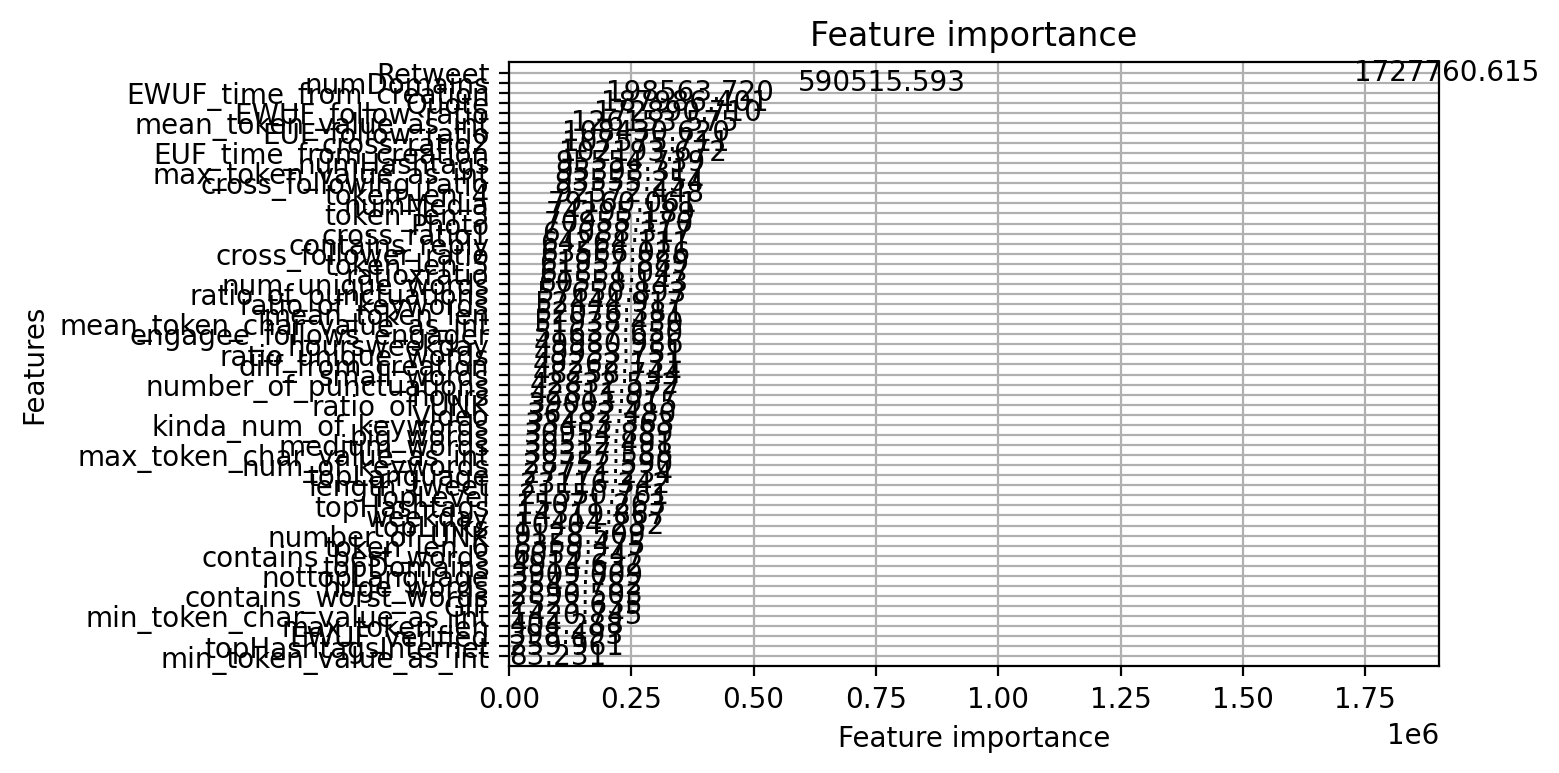

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
lgb.plot_importance(model_wd, importance_type='gain', max_num_features= 62)

### Feature importance plots

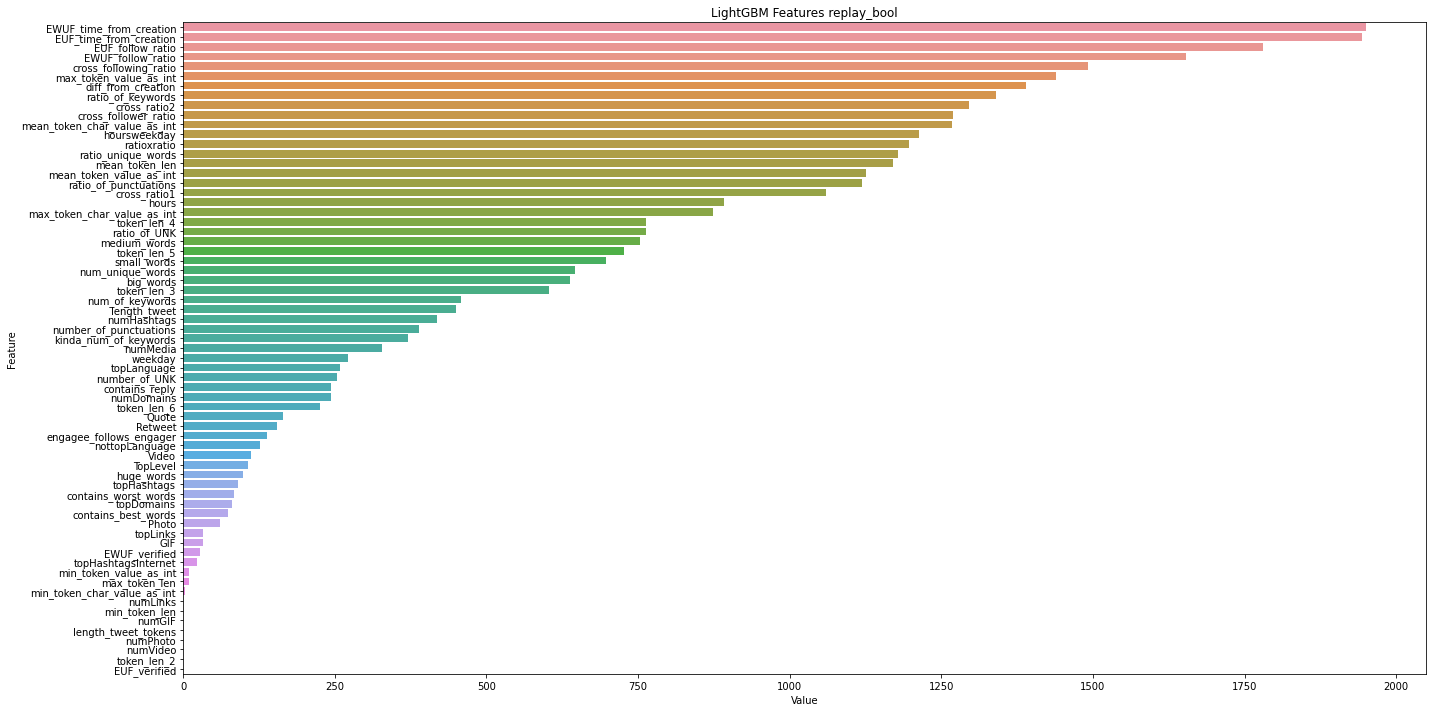

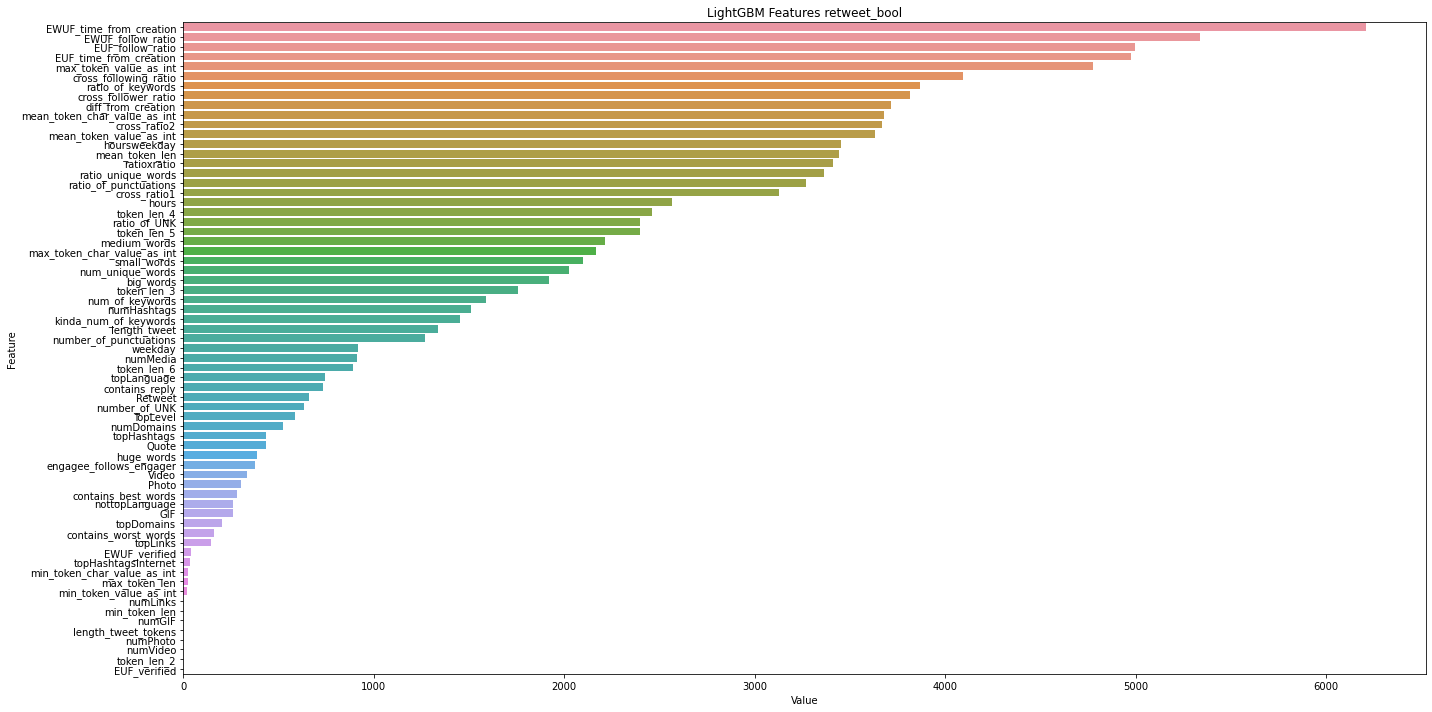

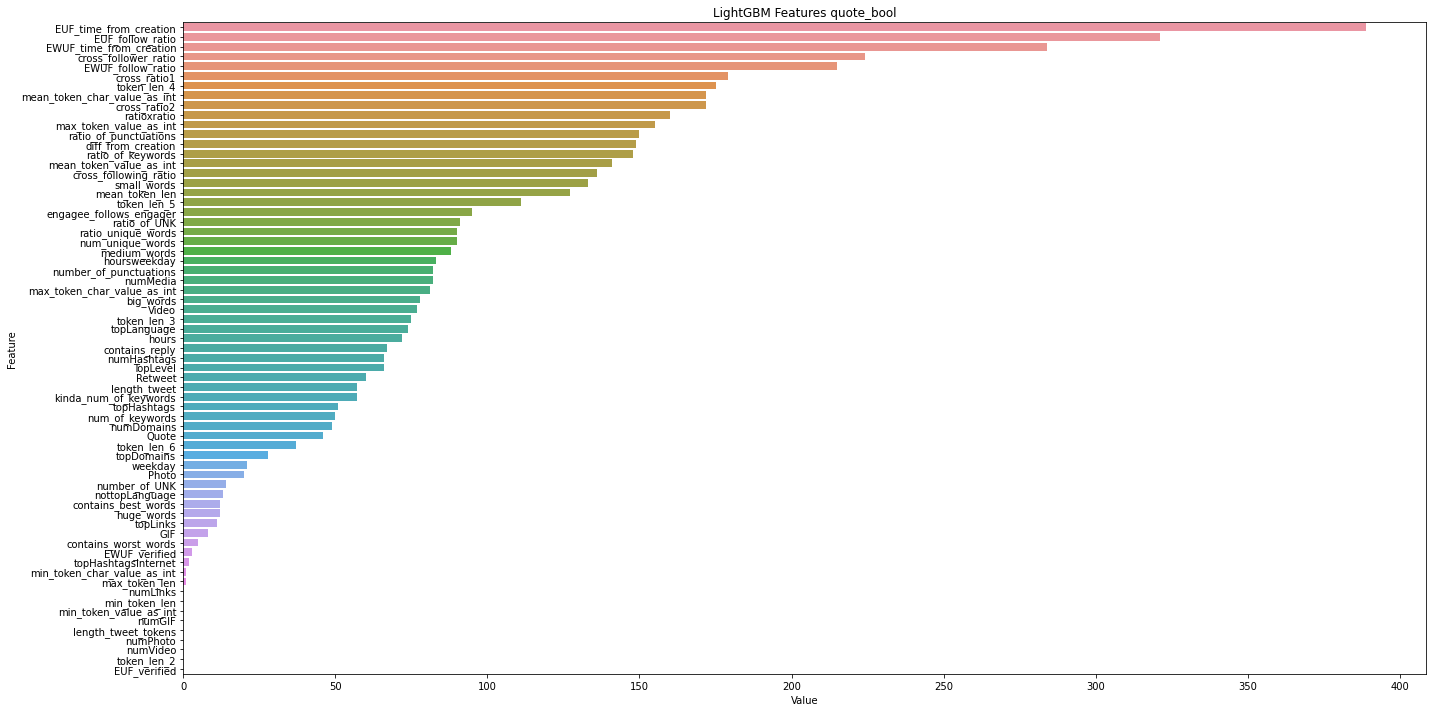

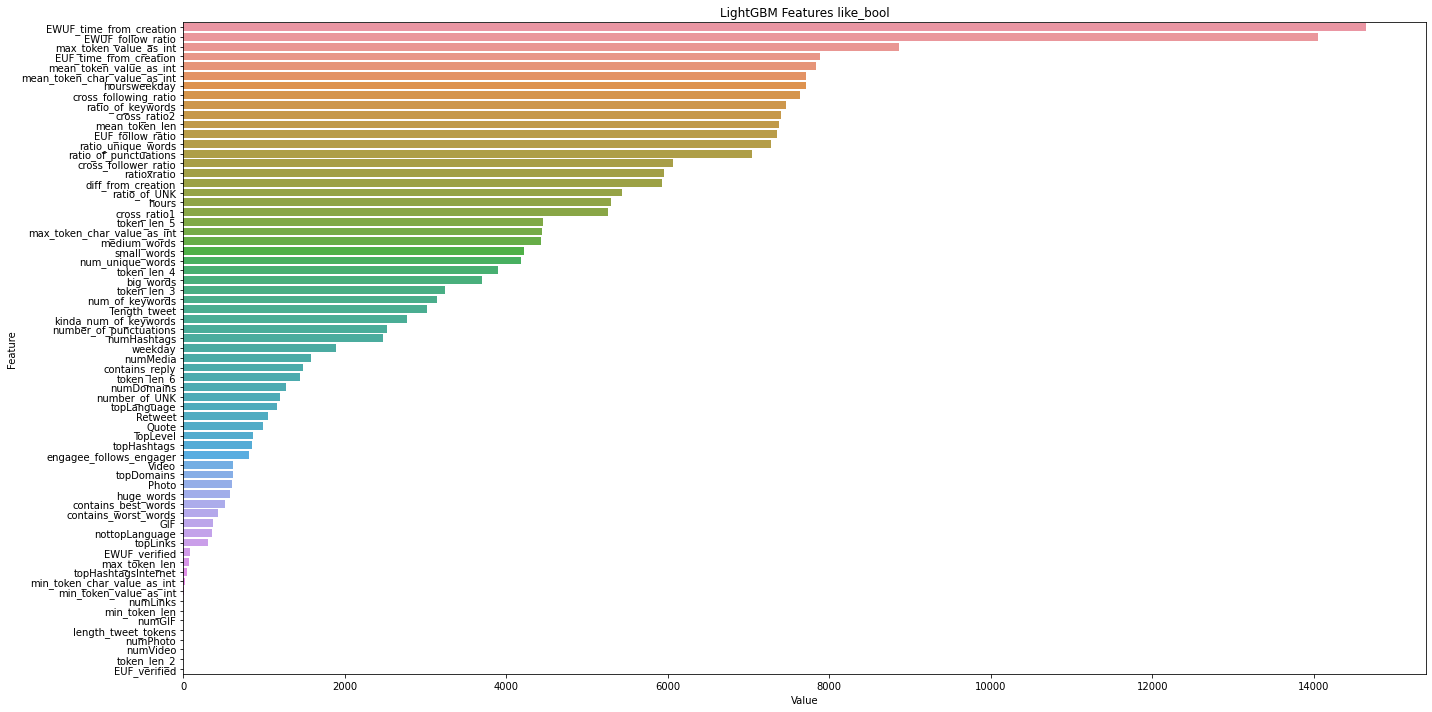

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

hoursCombinations = ['EUF_time_from_creation', 'EWUF_time_from_creation', 'diff_from_creation', 'weekday', 'hoursweekday']

text_features = ['length_tweet', 'num_unique_words', 'ratio_unique_words', 'contains_worst_words', 'contains_best_words', 'contains_reply', 'max_token_len', 'min_token_len', 'mean_token_len',
                 'number_of_UNK', 'ratio_of_UNK', 'number_of_punctuations', 'ratio_of_punctuations', 'kinda_num_of_keywords', 'num_of_keywords', 'ratio_of_keywords', 'length_tweet_tokens',
                  'token_len_2', 'token_len_3', 'token_len_4', 'token_len_5', 'token_len_6', 'mean_token_value_as_int', 'max_token_value_as_int', 'min_token_value_as_int',
                 'mean_token_char_value_as_int', 'max_token_char_value_as_int', 'min_token_char_value_as_int', 'huge_words', 'big_words', 'medium_words', 'small_words']

selected_features = ['EWUF_verified', 'EUF_verified', 'engagee_follows_engager', 'ratioxratio', 'hours', 'EWUF_follow_ratio', 'EUF_follow_ratio', 
                     'topHashtags', 'cross_following_ratio', 'cross_follower_ratio', 'cross_ratio1', 'cross_ratio2', 'topLanguage', 'nottopLanguage', 
                     'topHashtagsInternet', 'numHashtags', 'topDomains', 'numDomains', 'numVideo', 'numPhoto', 'numGIF', 
                     'topLinks', 'numLinks', 'Retweet', 'Quote', 'TopLevel', 'Photo', 'Video', 'GIF', 
                     'numMedia'] + hoursCombinations + text_features # + popular_hashtags_encoded 

for i,target in enumerate(targets):
  filename = 'ultramodel' + target + 'delaparrav2.sav'
  model = pickle.load(open(path + '/final/' + filename, 'rb'))

  # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
  feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),selected_features)), columns=['Value','Feature'])

  plt.figure(figsize=(20, 10))
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
  plt.title('LightGBM Features '+ target)
  plt.tight_layout()
  # plt.show()
  plt.savefig(path + '/final/' + 'lgbm_importances'+ target + '_mixed_nrt.png')

# Test

# Load data

In [ ]:
import pandas as pd
# import dask.array as da
# import dask.dataframe as dd
import os
import numpy as np


path = './gdrive/MyDrive/validation/'
df =  pd.read_csv(path + 'part-00000', sep='', encoding='utf-8', header=None) 
all_features = ['bert', 'hashtags', 'tweet_id', 'media', 'links', 'domains', 'type',
       'language', 'timestamp', 'EWUF_user_id', 'EWUF_follower_count',
       'EWUF_following_count', 'EWUF_verified', 'EWUF_account_creation',
       'EUF_user_id', 'EUF_follower_count', 'EUF_following_count',
       'EUF_verified', 'EUF_account_creation', 'engagee_follows_engager',
       'replay_timestamp', 'retweet_timestamp', 'quote_timestamp',
       'like_timestamp']
       
df.columns = all_features

### Load same array as training for not repeating tweets


In [ ]:
# load array
unique_tweet_id = (pd.read_csv(path + 'unique_tweet_id.csv', delimiter = ';', header = None)).values.flatten()

df_train = df[df['tweet_id'].isin(unique_tweet_id[:int(unique_tweet_id.shape[0]/2)])]
df_test = df[df['tweet_id'].isin(unique_tweet_id[int(unique_tweet_id.shape[0]/2):])]
np.savetxt(path + 'unique_tweet_id.csv', unique_tweet_id, delimiter=',', fmt='%s')

In [ ]:
df_test = df_test.sample(frac=0.4, replace=True, random_state=1) # make smaller test set

### Split with repeating tweets

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split( df, test_size=0.5, random_state=17)

In [ ]:
df_test = df_test.sample(frac=0.4, replace=True, random_state=1) # make smaller test set

### Liberate memory

In [ ]:
del df_train, df

# Transformation

### Run transformation functions

In [ ]:
from datetime import datetime


timestamp_columns = ['timestamp','EUF_account_creation', 'EWUF_account_creation','replay_timestamp','retweet_timestamp','quote_timestamp','like_timestamp']
hoursCombinations = ['EUF_time_from_creation', 'EWUF_time_from_creation', 'diff_from_creation', 'weekday', 'hoursweekday']
popular_hashtags_encoded = ['06B910C9B63253EC90A2CFEFDBCA16CE', '39C7D662C61AA442BA20D2A006EAA12E', '7E9AEB766F61E95966456D010AD862AF', '30B81B3A82D3B7BB28B0665B9BDB64B4',
                              'C1B1B9901E33AA2663BE92BE667A022A', '5C7186255EA0910671FE63609A7740C3', 'EEDFB04300BC76ECE64AE7AB8DFF999C', 'D145847A7C57F6DE2E7C16CA981F29CA',
                              '50D49D761DBC587AD19073D8A41BE4D0', '9004114120258A56A5F42E1B321E5D4D', '7A58C9993F3EDDEEE0193CF84AACB435',
                              'C97F51206BB66832B1B76DE40C7936E2', '01A8672B101954842C0D6809ADE4C250', '620B9E3FE9B8231E8767F3731E1E74E1', '1A69D94DA6E8A5D1F79192D3FB80C775', 
                              '7683BBB548DE14CCB45ACA60F0AD9B83', '86101A70061DA4A3A216AE11F48BD5E1','C442A089DA33B1C7411F3CC6274F60E2', '580CF8A679C838C2C063A631744A7B22', '05BBC3A142403B01286F8A8ABDB2EEFF', '91C8A9A97AF0D1B666ABC447B808B812',
                           '15ED32AEEAD0896AAE12BA7850052B94', '86F5C36DD25C658130A4F125005CE8EB', '95247C93BA4711381143E86AB039407E', '19875E4EA694E7A74B4025ECCF4E19CF',
                           '9B597ACF49E09186820C359759D325FF', 'D9F46EFE32A7D46EACAD96E4D552054B', 'AC6785EF8C88D1509EF755EAAEA4C875', 'BBD612D7A4C2EB59B3334456AB2D70A3',
                           '08C02CD16B3412A168D03171FA80C58E', 'C7DB5645FD9D5D8B81407F819CE78A06', '881264CF821C09C4F851A080C82CA83D']
worst_words_retweet = [
    "game", "going", "haha", "lol", "but", "watching", "work", "home", "night",
    "bed", "well", "sleep", "gonna", "hey", "tomorrow", "tired", "some",
    "back", "bored", "listening"
]

worst_words_encoded = ['11661','19090','10228','10406','10473','84532','11424','11816','16903','30113','11206','63658','11783','10261','19132','71841','11152','12014','73823','109130']

best_words_retweet = [
    "you", "twitter", "please", "retweet", "post", "blog", "social", "free",
    "media", "help", "please retweet", "great", "social media", "10", "follow",
    "how to", "top", "blog post", "check out", "new blogpost"
]

best_words_encoded = ['13028','188','20648','62893','11841','31907','12142','13961','12518','15217','20648','14772','12142','10150','28086','14796','12364','31907','43662','10751']

common_english_words = [
    'the', 'at', 'and', 'a', 'to', 'in', 'is', 'you', 'that', 'it', 'he',
    'was', 'for', 'on', 'are', 'as', 'with', 'his', 'they', 'i', 'at', 'be',
    'this', 'have', 'from', 'or', 'one', 'had', 'by', 'word', 'but', 'not',
    'what', 'all', 'were', 'we', 'when', 'your', 'can', 'said', 'there', 'use',
    'an', 'each', 'which', 'she', 'do', 'how', 'their', 'if', 'will', 'up',
    'other', 'about', 'out', 'many', 'then', 'them', 'these', 'so', 'some',
    'her', 'would', 'make', 'like', 'him', 'into', 'time', 'has', 'look',
    'two', 'more', 'write', 'go', 'see', 'number', 'no', 'way', 'could',
    'people', 'my', 'than', 'first', 'water', 'been', 'call', 'who', 'oil',
    'its', 'now', 'find', 'long', 'down', 'day', 'did', 'get', 'come', 'made',
    'may', 'part', '[SEP]', '[CLS]', 'https', 'http'
]

common_words_encoded = ['10105','10160','10111','169','10114','10106','10124','13028','10189','10271','10261','10134','10142','10135','10301','10146',
'10169','10226','10689','177','10160','10347','10531','10529','10188','10345','10464','10374','10155','12307','10473','10472','12976','10435','10309',
'11951','10841','20442','10944','12415','11155','11760','10151','11948','10319','10833','10149','14796','10455','12277','11337','10741','10684','10978',
'10950','11299','11059','11345','11762','10380','11152','10485','10894','13086','11850','10957','10708','10635','10393','25157','10551','10798','28685',
'11783','12888','11487','10192','13170','12174','11426','15127','11084','10422','12286','10590','20575','10479','21073','10474','11858','17860','11695',
'12935','11940','12172','15329','10678','11019','11387','10668','102','101','14120','10556']

addmited_punctuations = '100'

encoded_punctuations = ['106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','131','132','133','134','135','136','137','164','165','166','167','168','100','195','196','197','198']

text_columns = [
    'length_tweet', 'num_unique_words', 'ratio_unique_words',
    'contains_worst_words', 'contains_best_words', 'contains_reply',
    "max_token_len", "min_token_len", "mean_token_len", "number_of_UNK",
    "ratio_of_UNK", "number_of_punctuations", "ratio_of_punctuations",
    "kinda_num_of_keywords", "num_of_keywords", "ratio_of_keywords",
    "length_tweet_tokens" #, "tf_idf"
]

def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    #assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    mylist_of_strings = []
    for x in mylist:
        mylist_of_strings.append(str(x))

    return mylist_of_strings

def transform_basic_features(df, timestamp_columns = timestamp_columns):
    df[timestamp_columns] = df[timestamp_columns].apply(lambda x: pd.to_datetime(x,unit='s'))

    df['EWUF_follow_ratio'] = (df['EWUF_following_count']/ df['EWUF_follower_count'].apply(lambda x : x+1e-6) )
    df['cross_following_ratio'] = (df['EWUF_following_count']/ df['EUF_following_count'].apply(lambda x : x+1e-6) )
    df['cross_ratio1'] = (df['EWUF_following_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )
    df['cross_ratio2'] = (df['EUF_following_count']/ df['EWUF_follower_count'].apply(lambda x : x+1e-6) )
    df['EUF_follow_ratio'] = (df['EUF_following_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )
    df['cross_follower_ratio'] = (df['EWUF_follower_count']/ df['EUF_follower_count'].apply(lambda x : x+1e-6) )

    df['EUF_verified'] = df['EUF_verified'].astype(int)
    df['EWUF_verified'] = df['EUF_verified'].astype(int)
    df['EUF_time_from_creation'] = df.EUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
    df['EWUF_time_from_creation'] =  df.EWUF_account_creation.apply(lambda x: (datetime.now() - x).total_seconds()/60)
    df['diff_from_creation'] = (df.EUF_time_from_creation - df.EWUF_time_from_creation)
    df['engagee_follows_engager'] = df['engagee_follows_engager'].astype(int)
    df['ratioxratio'] = df['EWUF_follow_ratio']*df['EUF_follow_ratio']
    df['relevance'] = df['EUF_verified'] & df['EWUF_verified']

    df['replay_bool'] = df['replay_timestamp'].notna().astype(int)
    df['retweet_bool'] = df['retweet_timestamp'].notna().astype(int)
    df['quote_bool'] = df['quote_timestamp'].notna().astype(int)
    df['like_bool'] = df['like_timestamp'].notna().astype(int)

    df['numHashtags'] = df.hashtags.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numLinks'] = df.links.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numDomains'] = df.domains.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numMedia'] = df.media.apply(lambda x: len(str(x).split('\t')) if pd.isna(x) == False else 0)
    df['numVideo'] = df.media.apply(lambda x: x.count('Video') if pd.isna(x) == False else 0).sum()
    df['numPhoto'] = df.media.apply(lambda x: x.count('Photo') if pd.isna(x) == False else 0).sum()
    df['numGIF'] = df.media.apply(lambda x: x.count('GIF') if pd.isna(x) == False else 0).sum()
    return df

def transform_OHE(df, n = 40):
    # dummies of media
    df['Video'] = df.media.str.contains('Video', na=False).map({
        True: 1,
        False: 0
    })
    df['Photo'] = df.media.str.contains('Photo', na=False).map({
        True: 1,
        False: 0
    })
    df['GIF'] = df.media.str.contains('GIF', na=False).map({True: 1, False: 0})

    # dummies of type
    dummies = pd.get_dummies(df.type)
    df = pd.concat([df, dummies], axis=1)

    df['hours'] = df.timestamp.dt.hour
    df['weekday'] = df.timestamp.dt.weekday
    df['hoursweekday'] = df['hours']/24 + df['weekday']/7

    topLanguage = df['language'].value_counts()[:6].index.tolist()
    pattern = '|'.join(list(topLanguage))
    df['topLanguage'] = df.language.str.contains(pattern).replace({pd.NA : False}).astype(int)

    nottopLanguage = df['language'].value_counts()[20:].index.tolist()
    pattern = '|'.join(list(nottopLanguage))
    df['nottopLanguage'] = df.language.str.contains(pattern).replace({pd.NA : False}).astype(int)

    topHashtags = df['hashtags'].value_counts()[:n].index.tolist()
    pattern = '|'.join(list(topHashtags))
    df['topHashtags'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)

    topDomains = df['domains'].value_counts()[:n].index.tolist()
    pattern = '|'.join(list(topDomains))
    df['topDomains'] = df.domains.str.contains(pattern).replace({pd.NA : False}).astype(int)

    topLinks = df['links'].value_counts()[:n].index.tolist()
    pattern = '|'.join(list(topLinks))
    df['topLinks'] = df.links.str.contains(pattern).replace({pd.NA : False}).astype(int)
    return df

def transform_popular_hashtags(df, popular_hashtags_encoded = popular_hashtags_encoded):
    pattern = '|'.join(list(popular_hashtags_encoded))
    df['topHashtagsInternet'] = df.hashtags.str.contains(pattern).replace({pd.NA : False}).astype(int)
    return df

def text_features_fun(df_text):

    # cheap
    print("Tweet length")
    df_text["length_tweet"] = df_text.bert.apply(lambda x: len(x.split('\t')))
    print("Num unique words")
    df_text["num_unique_words"] = df_text["bert"].apply(lambda x: len(set(x.split('\t'))))
    print("Ratio unique words")
    df_text["ratio_unique_words"] = df_text["num_unique_words"] / df_text["length_tweet"]
    print("Contains worst words")
    df_text["contains_worst_words"] = df_text["bert"].apply(lambda x: int(len(set(x.split('\t')).intersection(set(worst_words_encoded))) != 0))
    print("Contains best words")
    df_text["contains_best_words"] = df_text["bert"].apply(lambda x: int(len(set(x.split('\t')).intersection(set(best_words_encoded))) != 0))
    print("Contains reply (@)")
    df_text["contains_reply"] = df_text["bert"].apply(lambda x: int('137' in x.split('\t')))


    # invented
    # ----------------------------------------------------------------------------------------------------------------------------------------
    # number of tokens of len something
    print("Number of token len 2")
    df_text["token_len_2"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 2)]))
    print("Number of token len 3")
    df_text["token_len_3"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 3)]))
    print("Number of token len 4")
    df_text["token_len_4"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 4)]))
    print("Number of token len 5")
    df_text["token_len_5"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 5)]))
    print("Number of token len 6")
    df_text["token_len_6"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) == 6)]))

    # mean sum of value of token as int
    print("Mean token len as int")
    df_text["mean_token_value_as_int"] = df_text["bert"].apply(lambda x: np.mean([int(word) for word in x.split('\t')]))

    # max and min token value as int
    print("Max token len as int")
    df_text["max_token_value_as_int"] = df_text["bert"].apply(lambda x: np.max([int(word) for word in x.split('\t')]))
    print("Min token len as int")
    df_text["min_token_value_as_int"] = df_text["bert"].apply(lambda x: np.min([int(word) for word in x.split('\t')]))

    # mean sum of value of token split into characters as int
    print("Maean token char len as int")
    df_text["mean_token_char_value_as_int"] = df_text["bert"].apply(lambda x: np.mean([sum(map(int, list(word))) for word in x.split('\t')]))

    # max and min token value into characters as int
    print("Max token char len as int")
    df_text["max_token_char_value_as_int"] = df_text["bert"].apply(lambda x: np.max([sum(map(int, list(word))) for word in x.split('\t')]))
    print("Min token char len as int")
    df_text["min_token_char_value_as_int"] = df_text["bert"].apply(lambda x: np.min([sum(map(int, list(word))) for word in x.split('\t')]))

    # number of huge words
    df_text["huge_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) >= 35]))
    # number of big words
    df_text["big_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) >= 20 and sum(map(int, list(word))) < 35]))
    # number of medium words
    df_text["medium_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) >= 10 and sum(map(int, list(word))) < 20]))
    # number of small words
    df_text["small_words"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if sum(map(int, list(word))) < 10]))

    # --------------------------------------------------------------------------------------------------------------------------------------

    print("Max token len")
    df_text["max_token_len"] = df_text["bert"].apply(lambda x: np.max([len(word) for word in x.split('\t')]))
    print("Min token len")
    df_text["min_token_len"] = df_text["bert"].apply(lambda x: np.min([len(word) for word in x.split('\t')]))
    print("Mean token len")
    df_text["mean_token_len"] = df_text["bert"].apply(lambda x: np.mean([len(word) for word in x.split('\t')]))
    print("Number of UNK")
    df_text["number_of_UNK"] = df_text["bert"].apply(lambda x: x.split('\t').count('100'))
    print("Ratio of UNK")
    df_text["ratio_of_UNK"] = (df_text['number_of_UNK'] /df_text['length_tweet']).astype(np.float32)

    print("Number of punctuations")
    df_text["number_of_punctuations"] = df_text["bert"].apply(lambda x: len([c for c in x.split('\t') if c in encoded_punctuations and c!= '100']))
    print("Ratio of punctuations")
    df_text["ratio_of_punctuations"] = (df_text['number_of_punctuations'] / df_text['length_tweet']).astype(np.float32)
    print("Kinda Num of keywords")
    df_text["kinda_num_of_keywords"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if word not in common_words_encoded]))
    print("Num of keywords")
    df_text["num_of_keywords"] = df_text["bert"].apply(lambda x: len([word for word in x.split('\t') if (len(word) > 3) and word not in common_words_encoded]))
    print("Ratio of keywords")
    df_text["ratio_of_keywords"] = (df_text["num_of_keywords"] / df_text["length_tweet"]).astype(np.float32)
    print("Tweet length characters")
    df_text["length_tweet_tokens"] = df_text["bert"].apply(lambda x: len(x.split('\t')))
    return df_text

### Transform

In [ ]:
df_test = transform_basic_features(df_test, timestamp_columns = timestamp_columns)
df_test = transform_OHE(df_test, n = 40)
df_test = transform_popular_hashtags(df_test, popular_hashtags_encoded = popular_hashtags_encoded)
df_test = text_features_fun(df_test)

text_features = ['length_tweet', 'num_unique_words', 'ratio_unique_words', 'contains_worst_words', 'contains_best_words', 'contains_reply', 'max_token_len', 'min_token_len', 'mean_token_len',
                 'number_of_UNK', 'ratio_of_UNK', 'number_of_punctuations', 'ratio_of_punctuations', 'kinda_num_of_keywords', 'num_of_keywords', 'ratio_of_keywords', 'length_tweet_tokens',
                  'token_len_2', 'token_len_3', 'token_len_4', 'token_len_5', 'token_len_6', 'mean_token_value_as_int', 'max_token_value_as_int', 'min_token_value_as_int',
                 'mean_token_char_value_as_int', 'max_token_char_value_as_int', 'min_token_char_value_as_int', 'huge_words', 'big_words', 'medium_words', 'small_words']

selected_features = ['EWUF_verified', 'EUF_verified', 'engagee_follows_engager', 'ratioxratio', 'hours', 'EWUF_follow_ratio', 'EUF_follow_ratio', 
                     'topHashtags', 'cross_following_ratio', 'cross_follower_ratio', 'cross_ratio1', 'cross_ratio2', 'topLanguage', 'nottopLanguage', 
                     'topHashtagsInternet', 'numHashtags', 'topDomains', 'numDomains', 'numVideo', 'numPhoto', 'numGIF', 
                     'topLinks', 'numLinks', 'Retweet', 'Quote', 'TopLevel', 'Photo', 'Video', 'GIF', 
                     'numMedia'] + hoursCombinations + text_features # + popular_hashtags_encoded  

X = df_test[selected_features]
targets = ['replay_bool','retweet_bool','quote_bool','like_bool']
gt = df_test[targets]
del df_test

# Obtaining metrics

In [ ]:
from sklearn.metrics import average_precision_score, log_loss
import pickle 

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

path = './gdrive/MyDrive/validation/'
engagement = ['replay', 'retweet', 'quote', 'like']
for eng, target in zip(engagement, targets):
  print(eng)
  Model = pickle.load(open(path + 'ultramodel' + target + 'delaparrav2.sav', 'rb'))
  predictions = Model.predict(X)
  rce = compute_rce(predictions, gt[target].values)
  average_precision = average_precision_score(gt[target].values, predictions)
  print(f'RCE: {rce}')
  print(f'AP: {average_precision}')

replay
RCE: 10.97593773653186
AP: 0.08193966479789698
retweet
RCE: 9.639897219493587
AP: 0.22951359902995414
quote
RCE: 3.307594033564387
AP: 0.011573704350625227
like
RCE: 11.42074294887384
AP: 0.6118105768813841


# In case of wanting the metrics by group popularity, for the case of Like

### Quantiles

In [ ]:
# hay que correr la celda con las funciones y listas antes
df_test = transform_basic_features(df_test, timestamp_columns = timestamp_columns)
df_test = transform_OHE(df_test, n = 40)
df_test = transform_popular_hashtags(df_test, popular_hashtags_encoded = popular_hashtags_encoded)
df_test = text_features_fun(df_test)

text_features = ['length_tweet', 'num_unique_words', 'ratio_unique_words', 'contains_worst_words', 'contains_best_words', 'contains_reply', 'max_token_len', 'min_token_len', 'mean_token_len',
                 'number_of_UNK', 'ratio_of_UNK', 'number_of_punctuations', 'ratio_of_punctuations', 'kinda_num_of_keywords', 'num_of_keywords', 'ratio_of_keywords', 'length_tweet_tokens',
                  'token_len_2', 'token_len_3', 'token_len_4', 'token_len_5', 'token_len_6', 'mean_token_value_as_int', 'max_token_value_as_int', 'min_token_value_as_int',
                 'mean_token_char_value_as_int', 'max_token_char_value_as_int', 'min_token_char_value_as_int', 'huge_words', 'big_words', 'medium_words', 'small_words']

selected_features = ['EWUF_follower_count','EWUF_verified', 'EUF_verified', 'engagee_follows_engager', 'ratioxratio', 'hours', 'EWUF_follow_ratio', 'EUF_follow_ratio', 
                     'topHashtags', 'cross_following_ratio', 'cross_follower_ratio', 'cross_ratio1', 'cross_ratio2', 'topLanguage', 'nottopLanguage', 
                     'topHashtagsInternet', 'numHashtags', 'topDomains', 'numDomains', 'numVideo', 'numPhoto', 'numGIF', 
                     'topLinks', 'numLinks', 'Retweet', 'Quote', 'TopLevel', 'Photo', 'Video', 'GIF', 
                     'numMedia'] + hoursCombinations + text_features # + popular_hashtags_encoded  

X = df_test[selected_features]
targets = ['replay_bool','retweet_bool','quote_bool','like_bool']
gt = df_test[targets]
del df_test

Tweet length
Num unique words
Ratio unique words
Contains worst words
Contains best words
Contains reply (@)
Number of token len 2
Number of token len 3
Number of token len 4
Number of token len 5
Number of token len 6
Mean token len as int
Max token len as int
Min token len as int
Maean token char len as int
Max token char len as int
Min token char len as int
Max token len
Min token len
Mean token len
Number of UNK
Ratio of UNK
Number of punctuations
Ratio of punctuations
Kinda Num of keywords
Num of keywords
Ratio of keywords
Tweet length characters


In [ ]:
X['EWUF_quantiles'] = pd.qcut(X['EWUF_follower_count'], 5, labels=False)

In [ ]:
from sklearn.metrics import average_precision_score, log_loss
import pickle 

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

path = './gdrive/MyDrive/validation/'

quantiles = X['EWUF_quantiles'].unique()
selected_features2 = ['EWUF_verified', 'EUF_verified', 'engagee_follows_engager', 'ratioxratio', 'hours', 'EWUF_follow_ratio', 'EUF_follow_ratio', 
                     'topHashtags', 'cross_following_ratio', 'cross_follower_ratio', 'cross_ratio1', 'cross_ratio2', 'topLanguage', 'nottopLanguage', 
                     'topHashtagsInternet', 'numHashtags', 'topDomains', 'numDomains', 'numVideo', 'numPhoto', 'numGIF', 
                     'topLinks', 'numLinks', 'Retweet', 'Quote', 'TopLevel', 'Photo', 'Video', 'GIF', 
                     'numMedia'] + hoursCombinations + text_features # + popular_hashtags_encoded
for element in quantiles:
  print('quantile:', element)
  Model = pickle.load(open(path + 'ultramodel' + 'like_bool' + 'delaparrav2.sav', 'rb'))
  X_predict = X[X['EWUF_quantiles'] == element][selected_features2]
  predictions = Model.predict(X_predict)
  rce = compute_rce(predictions, gt['like_bool'][gt.index.isin(X_predict.index.tolist())])
  average_precision = average_precision_score(gt['like_bool'][gt.index.isin(X_predict.index.tolist())], predictions)
  print(f'RCE: {rce}')
  print(f'AP: {average_precision}')

quantile: 2
RCE: 10.078916431532047
AP: 0.5909487518988035
quantile: 4
RCE: 14.348490456433439
AP: 0.6604227002253256
quantile: 1
RCE: 9.538793998583184
AP: 0.5676294344710465
quantile: 0
RCE: 10.821822888008882
AP: 0.5927059628460276
quantile: 3
RCE: 11.693576718759747
AP: 0.6274876596659065
